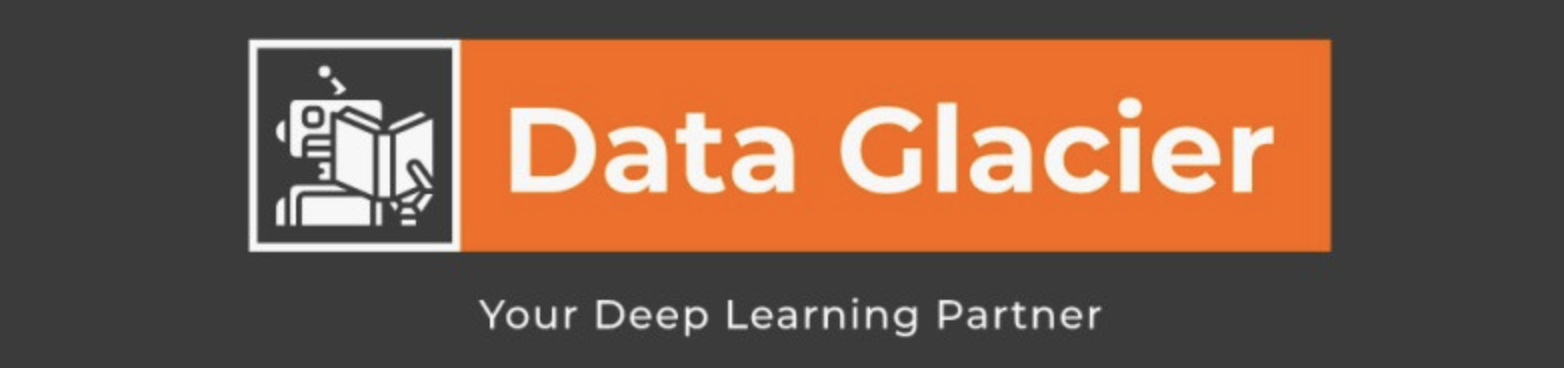

# Tasks : File Ingestion and Schema validation

- 1) Take any csv/text file of 2+ GB of your choice. --- (You can do this assignment on Google colab)

- 2) Read the file ( Present approach of reading the file )

- 3) Try different methods of file reading eg: Dask, Modin, Ray, pandas and present your findings in term of computational efficiency

- 4) Perform basic validation on data columns : eg: remove special character , white spaces from the col name

- 5) As you already know the schema hence create a YAML file and write the column name in YAML file. --define separator of
- 6) read and write file, column name in YAML

- 7) Validate number of columns and column name of ingested file with YAML.

- 8) Write the file in pipe separated text file (|) in gz format.

- 9) Create a summary of the file:

      - Total number of rows,

      - total number of columns

       - file size

## Task-1: THE CSV FILE WE ARE USING IS 2.86 GB LARGE AND CONTAINS PARKING TICKETS IN NEW YORK FOR THE YEAR 2015

# 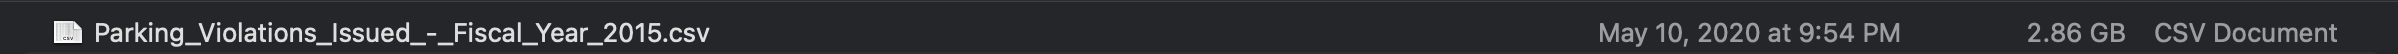

# Task 2 & 3 ; WE ARE IMPORTING PANDAS TO READ THE FILE

In [10]:
import pandas as pd
import time
start = time.time()
df = pd.read_csv('Parking_Violations_Issued_-_Fiscal_Year_2015.csv')
end = time.time()
print("Read csv with pandas: ",(end-start),"sec")

/var/folders/15/lpk5dtm54c13kp048zvdyty40000gn/T/ipykernel_84735/21274598.py:4: DtypeWarning: Columns (18,29,38,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Parking_Violations_Issued_-_Fiscal_Year_2015.csv')


Read csv with pandas:  106.95001196861267 sec


### As we can see, Pandas takes 106.95 secs which is not good enough

## Task 2 & 3: WE ARE IMPORTING DASK TO READ THE FILE

In [11]:
from dask import dataframe as dd
import time
start = time.time()
dask_df = dd.read_csv('Parking_Violations_Issued_-_Fiscal_Year_2015.csv')
end = time.time()
print("Read csv with dask: ",(end-start),"sec")

Read csv with dask:  0.04421806335449219 sec


### Dask takes 0.04sec which proves more efficient than pandas.

## Task 4 : Validation

In [66]:
#Number of Columns
len(df.columns)

51

In [12]:
# validating Dtype of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11809233 entries, 0 to 11809232
Data columns (total 51 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Summons Number                     int64  
 1   Plate ID                           object 
 2   Registration State                 object 
 3   Plate Type                         object 
 4   Issue Date                         object 
 5   Violation Code                     int64  
 6   Vehicle Body Type                  object 
 7   Vehicle Make                       object 
 8   Issuing Agency                     object 
 9   Street Code1                       int64  
 10  Street Code2                       int64  
 11  Street Code3                       int64  
 12  Vehicle Expiration Date            object 
 13  Violation Location                 float64
 14  Violation Precinct                 int64  
 15  Issuer Precinct                    int64  
 16  Issuer Code     

In [26]:
# Fixing the Dtype of error columns
dtypes = {
    'Meter Number': 'object',
    'Time First Observed': 'object',
    'Violation Location': 'float64'
}

## Task-5 : Creating a utility.py

In [16]:
%%writefile utility.py
import logging
import os
import subprocess
import yaml
import pandas as pd
import datetime 
import gc
import re

def read_config_file(filepath):
    with open(filepath, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            logging.error(exc)

def replacer(string, char):
    pattern = char + '{2,}'
    string = re.sub(pattern, char, string) 
    return string

def col_header_val(df,table_config):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace('[^\w]','_',regex=True)
    df.columns = list(map(lambda x: x.strip('_'), list(df.columns)))
    df.columns = list(map(lambda x: replacer(x,'_'), list(df.columns)))
    expected_col = list(map(lambda x: x.lower(),  table_config['columns']))
    expected_col.sort()
    df.columns =list(map(lambda x: x.lower(), list(df.columns)))
    df = df.reindex(sorted(df.columns), axis=1)
    if len(df.columns) == len(expected_col) and list(expected_col)  == list(df.columns):
        print("column name and column length validation passed")
        return 1
    else:
        print("column name and column length validation failed")
        mismatched_columns_file = list(set(df.columns).difference(expected_col))
        print("Following File columns are not in the YAML file",mismatched_columns_file)
        missing_YAML_file = list(set(expected_col).difference(df.columns))
        print("Following YAML columns are not in the file uploaded",missing_YAML_file)
        logging.info(f'df columns: {df.columns}')
        logging.info(f'expected columns: {expected_col}')
        return 0

Overwriting utility.py


## Task-6 : Creating a YAML fime called 'Parking.YAML'

In [36]:
%%writefile parking.yaml
file_type: csv
dataset_name: file
file_name: Parking_Violations_Issued_-_Fiscal_Year_2015
table_name: edsurv
inbound_delimiter: ","
outbound_delimiter: "|"
skip_leading_rows: 1
columns: 
    - Summons Number                    
    - Plate ID
    - Registration State
    - Plate Type 
    - Issue Date
    - Violation Code
    - Vehicle Body Type
    - Vehicle Make
    - Issuing Agency
    - Street Code1 
    - Street Code2 
    - Street Code3
    - Vehicle Expiration Date
    - Violation Location
    - Violation Precinct
    - Issuer Precinct
    - Issuer Code 
    - Issuer Command 
    - Issuer Squad
    - Violation Time
    - Time First Observed
    - Violation County
    - Violation In Front Of Or Opposite 
    - House Number
    - Street Name
    - Intersecting Street
    - Date First Observed
    - Law Section
    - Sub Division
    - Violation Legal Code
    - Days Parking In Effect
    - From Hours In Effect
    - To Hours In Effect
    - Vehicle Color
    - Unregistered Vehicle
    - Vehicle Year
    - Meter Number
    - Feet From Curb
    - Violation Post Code
    - Violation Description
    - No Standing or Stopping Violation
    - Hydrant Violation
    - Double Parking Violation 
    - Latitude
    - Longitude
    - Community Board
    - Community Council
    - Census Tract
    - BIN
    - BBL                  
    - NTA

Overwriting parking.yaml


In [40]:
# Reading config file
import utility as util
config_data = util.read_config_file("parking.yaml")

In [41]:
config_data['inbound_delimiter']

','

In [42]:
#inspecting data of config file
config_data

{'file_type': 'csv',
 'dataset_name': 'file',
 'file_name': 'Parking_Violations_Issued_-_Fiscal_Year_2015',
 'table_name': 'edsurv',
 'inbound_delimiter': ',',
 'outbound_delimiter': '|',
 'skip_leading_rows': 1,
 'columns': ['Summons Number',
  'Plate ID',
  'Registration State',
  'Plate Type',
  'Issue Date',
  'Violation Code',
  'Vehicle Body Type',
  'Vehicle Make',
  'Issuing Agency',
  'Street Code1',
  'Street Code2',
  'Street Code3',
  'Vehicle Expiration Date',
  'Violation Location',
  'Violation Precinct',
  'Issuer Precinct',
  'Issuer Code',
  'Issuer Command',
  'Issuer Squad',
  'Violation Time',
  'Time First Observed',
  'Violation County',
  'Violation In Front Of Or Opposite',
  'House Number',
  'Street Name',
  'Intersecting Street',
  'Date First Observed',
  'Law Section',
  'Sub Division',
  'Violation Legal Code',
  'Days Parking In Effect',
  'From Hours In Effect',
  'To Hours In Effect',
  'Vehicle Color',
  'Unregistered Vehicle',
  'Vehicle Year',
  'Me

In [43]:
# Normal reading process of the file
from dask import dataframe as dd


df_sample = dd.read_csv('Parking_Violations_Issued_-_Fiscal_Year_2015.csv', delimiter=',', dtype=dtypes)
df_sample.head()


,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Hydrant Violation,Double Parking Violation,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA
0,8002531292,EPC5238,NY,PAS,10/01/2014,21,SUBN,CHEVR,T,20390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8015318440,5298MD,NY,COM,03/06/2015,14,VAN,FRUEH,T,27790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7611181981,FYW2775,NY,PAS,07/28/2014,46,SUBN,SUBAR,T,8130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7445908067,GWE1987,NY,PAS,04/13/2015,19,4DSD,LEXUS,T,59990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7037692864,T671196C,NY,PAS,05/19/2015,19,4DSD,CHRYS,T,36090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
import pandas as pd 
# read the file using config file
file_type = config_data['file_type']
source_file = "./" + config_data['file_name'] + f'.{file_type}'

delimiter = config_data['inbound_delimiter']
df = pd.read_csv(source_file, delimiter=delimiter)
df.head()

/var/folders/15/lpk5dtm54c13kp048zvdyty40000gn/T/ipykernel_84735/1809367545.py:7: DtypeWarning: Columns (18,29,38,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(source_file, delimiter=delimiter)


,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Hydrant Violation,Double Parking Violation,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA
0,8002531292,EPC5238,NY,PAS,10/01/2014,21,SUBN,CHEVR,T,20390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8015318440,5298MD,NY,COM,03/06/2015,14,VAN,FRUEH,T,27790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7611181981,FYW2775,NY,PAS,07/28/2014,46,SUBN,SUBAR,T,8130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7445908067,GWE1987,NY,PAS,04/13/2015,19,4DSD,LEXUS,T,59990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7037692864,T671196C,NY,PAS,05/19/2015,19,4DSD,CHRYS,T,36090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Task-7  : Validating, header of the file and number of columns 

In [45]:
#validate the header of the file
util.col_header_val(df,config_data)

column name and column length validation failed
Following File columns are not in the YAML file ['sub_division', 'issuer_squad', 'no_standing_or_stopping_violation', 'street_code1', 'feet_from_curb', 'issuing_agency', 'date_first_observed', 'census_tract', 'law_section', 'meter_number', 'violation_county', 'issuer_precinct', 'vehicle_expiration_date', 'from_hours_in_effect', 'vehicle_color', 'street_code3', 'violation_precinct', 'violation_code', 'violation_location', 'vehicle_make', 'vehicle_body_type', 'violation_description', 'violation_in_front_of_or_opposite', 'time_first_observed', 'summons_number', 'to_hours_in_effect', 'community_council', 'street_name', 'plate_id', 'violation_legal_code', 'issuer_code', 'violation_time', 'vehicle_year', 'street_code2', 'unregistered_vehicle', 'intersecting_street', 'registration_state', 'days_parking_in_effect', 'hydrant_violation', 'issuer_command', 'issue_date', 'double_parking_violation', 'community_board', 'violation_post_code', 'plate_typ

0

In [46]:
print("columns of files are:" ,df.columns)
print("columns of YAML are:" ,config_data['columns'])

columns of files are: Index(['summons_number', 'plate_id', 'registration_state', 'plate_type',
       'issue_date', 'violation_code', 'vehicle_body_type', 'vehicle_make',
       'issuing_agency', 'street_code1', 'street_code2', 'street_code3',
       'vehicle_expiration_date', 'violation_location', 'violation_precinct',
       'issuer_precinct', 'issuer_code', 'issuer_command', 'issuer_squad',
       'violation_time', 'time_first_observed', 'violation_county',
       'violation_in_front_of_or_opposite', 'house_number', 'street_name',
       'intersecting_street', 'date_first_observed', 'law_section',
       'sub_division', 'violation_legal_code', 'days_parking_in_effect',
       'from_hours_in_effect', 'to_hours_in_effect', 'vehicle_color',
       'unregistered_vehicle', 'vehicle_year', 'meter_number',
       'feet_from_curb', 'violation_post_code', 'violation_description',
       'no_standing_or_stopping_violation', 'hydrant_violation',
       'double_parking_violation', 'latitude', '

In [48]:
if util.col_header_val(df,config_data)==0:
    print("validation failed")
else:
    print("column validation passed")

column name and column length validation failed
Following File columns are not in the YAML file ['sub_division', 'issuer_squad', 'no_standing_or_stopping_violation', 'street_code1', 'feet_from_curb', 'issuing_agency', 'date_first_observed', 'census_tract', 'law_section', 'meter_number', 'violation_county', 'issuer_precinct', 'vehicle_expiration_date', 'from_hours_in_effect', 'vehicle_color', 'street_code3', 'violation_precinct', 'violation_code', 'violation_location', 'vehicle_make', 'vehicle_body_type', 'violation_description', 'violation_in_front_of_or_opposite', 'time_first_observed', 'summons_number', 'to_hours_in_effect', 'community_council', 'street_name', 'plate_id', 'violation_legal_code', 'issuer_code', 'violation_time', 'vehicle_year', 'street_code2', 'unregistered_vehicle', 'intersecting_street', 'registration_state', 'days_parking_in_effect', 'hydrant_violation', 'issuer_command', 'issue_date', 'double_parking_violation', 'community_board', 'violation_post_code', 'plate_typ

## Task-8 : Creating a file called 'newfile.csv.gz' in pipe separated text file (|) in gz format.

In [58]:
import csv
import gzip

data = dd.read_csv('Parking_Violations_Issued_-_Fiscal_Year_2015.csv',delimiter=',')

output_file = 'Newfile.csv.gz'

with gzip.open(output_file, 'wt', encoding='utf-8') as file:
    writer = csv.writer(file, delimiter='|')
    writer.writerows(data)


print(f"File '{output_file}' has been written in gzipped format.")


File 'Newfile.csv.gz' has been written in gzipped format.


In [70]:
pd.read_csv("Newfile.csv.gz")

,S|u|m|m|o|n|s| |N|u|m|b|e|r
0,P|l|a|t|e| |I|D
1,R|e|g|i|s|t|r|a|t|i|o|n| |S|t|a|t|e
2,P|l|a|t|e| |T|y|p|e
3,I|s|s|u|e| |D|a|t|e
4,V|i|o|l|a|t|i|o|n| |C|o|d|e
5,V|e|h|i|c|l|e| |B|o|d|y| |T|y|p|e
6,V|e|h|i|c|l|e| |M|a|k|e
7,I|s|s|u|i|n|g| |A|g|e|n|c|y
8,S|t|r|e|e|t| |C|o|d|e|1
9,S|t|r|e|e|t| |C|o|d|e|2


## Task 9 : Creating a summary of the file

In [71]:
import os

input_file = 'Newfile.csv.gz'  # Provide the correct file path

# Initialize counters
total_rows = 0
total_columns = 0


# Open the gzipped file and read it with csv.reader
with gzip.open(input_file, 'rt', encoding='utf-8') as file:
    reader = csv.reader(file, delimiter='|')
    # Iterate over the rows without storing them in memory
    total_rows = sum(1 for _ in reader)

print(f"Total number of rows: {total_rows}")

# Get the file size
file_size = os.path.getsize(input_file)

# Print the summary

print(f"Total number of columns: {total_columns}")
print(f"File size: {file_size} bytes")

Total number of rows: 51
Total number of columns: 0
File size: 547 bytes
